# Simple usage

This notebook demonstrates basic usage of the *openTSNE* library. This is sufficient for almost all use-cases.

In [1]:
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In most of the notebooks, we will be using the Macosko 2015 mouse retina data set. This is a fairly well-known and well explored data set in the single-cell literature making it suitable as an example.

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Run t-SNE

We'll first create an embedding on the training data.

In [6]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    callbacks=ErrorLogger(),
    n_jobs=8,
    random_state=42,
)

In [7]:
%time embedding_train = tsne.fit(x_train)

Iteration   50, KL divergence  5.7901, 50 iterations in 1.1000 sec
Iteration  100, KL divergence  5.2511, 50 iterations in 0.9657 sec
Iteration  150, KL divergence  5.1615, 50 iterations in 0.9991 sec
Iteration  200, KL divergence  5.1268, 50 iterations in 0.9726 sec
Iteration  250, KL divergence  5.1076, 50 iterations in 1.0095 sec
Iteration   50, KL divergence  3.8025, 50 iterations in 1.0352 sec
Iteration  100, KL divergence  3.4117, 50 iterations in 1.0946 sec
Iteration  150, KL divergence  3.1974, 50 iterations in 1.2869 sec
Iteration  200, KL divergence  3.0556, 50 iterations in 1.4492 sec
Iteration  250, KL divergence  2.9535, 50 iterations in 1.8365 sec
Iteration  300, KL divergence  2.8751, 50 iterations in 2.0608 sec
Iteration  350, KL divergence  2.8137, 50 iterations in 2.5188 sec
Iteration  400, KL divergence  2.7644, 50 iterations in 3.5575 sec
Iteration  450, KL divergence  2.7245, 50 iterations in 3.2463 sec
Iteration  500, KL divergence  2.6918, 50 iterations in 3.6766

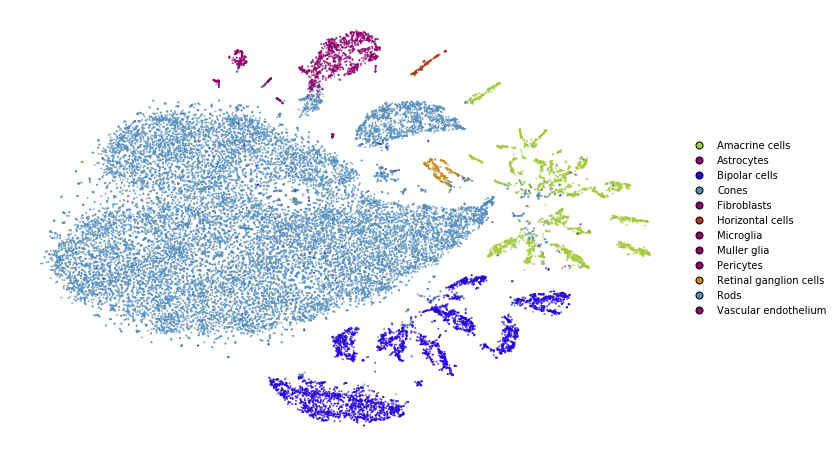

In [8]:
utils.plot(embedding_train, y_train, colors=utils.MACOSKO_COLORS)

## Transform

openTSNE is currently the only library that allows embedding new points into an existing embedding.

In [9]:
%time embedding_test = embedding_train.transform(x_test)

Iteration   50, KL divergence  212552.5028, 50 iterations in 6.0102 sec
Iteration  100, KL divergence  212498.8526, 50 iterations in 5.6037 sec
CPU times: user 1min 31s, sys: 155 ms, total: 1min 32s
Wall time: 12.5 s


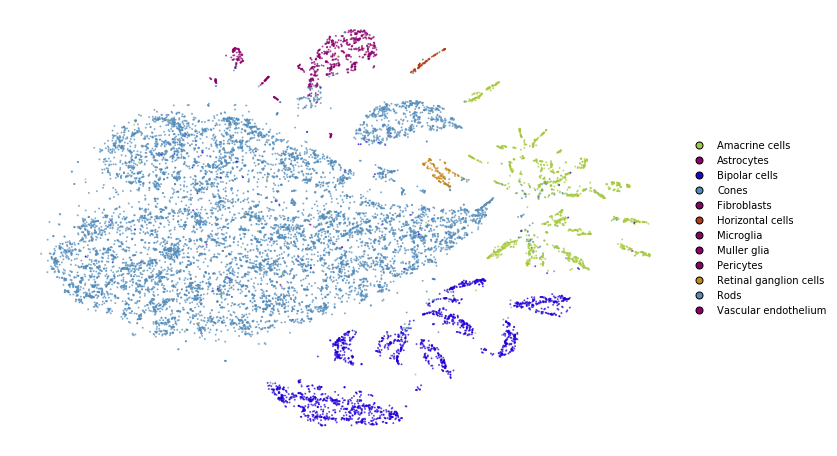

In [10]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

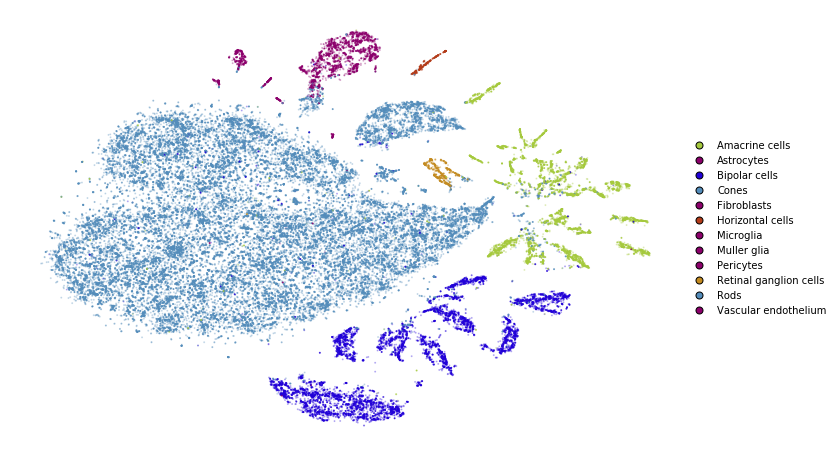

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
utils.plot(embedding_train, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)